# Import libreries

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import ImageOps, Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib
#matplotlib.use('Agg')

In [2]:
print(tf.__version__)

2.6.0


# Define colors

In [3]:
# From color_info.txt -> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py#L52-L99

# Class names
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
         'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']

# Class colors
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
          (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
          (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), 
          (0, 0, 142)], dtype = np.int32)

# Class info
#pd.DataFrame({'Names': names, 'Colour': [col for col in colors]})

# Read images

In [4]:
# Define paths
train_images_folder_path = "./Data/Train_data/Images"  #"/content/drive/My Drive/TFM/Train_data/Images"
train_mask_folder_path = "./Data/Train_data/Labels"  #"/content/drive/My Drive/TFM/Train_data/Labels"
test_images_folder_path = "./Data/Validation_data/Images"  #"/content/drive/My Drive/TFM/Validation_data/Images"
test_mask_folder_path = "./Data/Validation_data/Labels"  #"/content/drive/My Drive/TFM/Validation_data/Labels"

# Get images and masks names
train_images_names = sorted([img for img in os.listdir(train_images_folder_path) if img.endswith('.png')])
train_mask_names = sorted([img for img in os.listdir(train_mask_folder_path) if img.endswith('.png')])
test_images_names = sorted([img for img in os.listdir(test_images_folder_path) if img.endswith('.png')])
test_mask_names = sorted([img for img in os.listdir(test_mask_folder_path) if img.endswith('.png')])

train_images_names = train_images_names[300:]
train_mask_names = train_mask_names[300:]
val_images_names = train_images_names[:300]
val_mask_names = train_mask_names[:300]


# Count check
print(f'Train images: {len(train_images_names)}')
print(f'Train labels: {len(train_mask_names)}')
print(f'Val images: {len(val_images_names)}')
print(f'Val labels: {len(val_mask_names)}')
print(f'Validation images: {len(test_images_names)}')
print(f'Validation labels: {len(test_mask_names)}')

Train images: 2675
Train labels: 2675
Val images: 300
Val labels: 300
Validation images: 500
Validation labels: 500


In [5]:
# Define image shape. Images are 1024 x 2048 (height x width) -> (896) 768 x 2048 after the crop, so to maintain the ratio: 
img_height, img_width = 96, 256  #112, 256
batch_size = 32

def one_hot_mask(y):
    ''' Do the one hot encoding for the masks.
  
    Arguments:
        - y (tf tensor): Mask of shape (height, width, 3)

    Returns:
        - mask (tf tensor): Mask after do the one hot. Shape (height, width, num_classes) '''

    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
        one_hot_map.append(class_map)
    mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
    return mask



def load_image(folder, file, height = 96, width = 256, crop = True):
    ''' Load and preprocess a train image by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Normalize the image to [0, 1]
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed image '''

    # Load the image (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)

    # Crop the image
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the image
    image = tf.image.resize(image, (height, width))

    # Normalize the image
    image = tf.cast(image, tf.float32)/255.0
    return image



def load_mask(folder, file, height = 96, width = 256, one_hot = True, crop = True):
    ''' Load and preprocess a train mask by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Reshaping the mask from (height, width, 3) to (height, width, 30): One hot encoding
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - one_hot (bool): Do one hot encoding or not -- True
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed mask '''

    # Load the mask (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)

    # Crop the mask
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the mask
    image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # One hot encoding
    if one_hot:
        image = one_hot_mask(image)
    return image



def load_train(image_name, mask_name):
    ''' Load and preprocess a train image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(train_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(train_mask_folder_path, mask_name, img_height, img_width)
    return image, mask



def load_val(image_name, mask_name):
    ''' Load and preprocess a validation image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(test_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(test_mask_folder_path, mask_name, img_height, img_width)
    return image, mask

In [6]:
# Check mask shape after one hot encoding
print(load_mask(train_mask_folder_path, train_mask_names[0], img_height, img_width).shape)

(96, 256, 30)


In [7]:
# Create train tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_names, train_mask_names))
train_dataset = train_dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
print(train_dataset)

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>


In [8]:
# Create validation tensorflow dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_names, val_mask_names))
val_dataset = val_dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
print(val_dataset)

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>


In [9]:
# Create test tensorflow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_names, test_mask_names))
test_dataset = test_dataset.map(load_val, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>


In [10]:
# Load the validation mask, one hot and get the correct value (96, 256, 1)
y_real_oh = np.argmax([load_mask(test_mask_folder_path, test_name, img_height, img_width, one_hot = True) for test_name in test_mask_names], axis = 3)

In [12]:
original_image = tf.io.read_file(train_images_folder_path + '/' + train_images_names[0])
original_image = tf.cast(tf.image.decode_png(original_image, channels = 3), tf.float32)
original_image = tf.cast(original_image, tf.float32)/255.0

original_mask = tf.io.read_file(train_mask_folder_path + '/' + train_mask_names[0])
original_mask = tf.cast(tf.image.decode_png(original_mask, channels = 3), tf.int32)

# Visualization

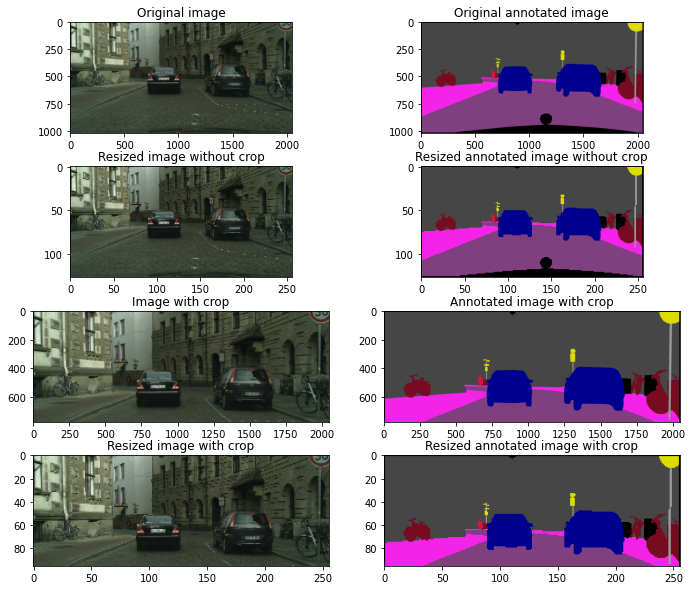

In [13]:
fig, ax = plt.subplots(4, 2, figsize = (12, 10))
ax[0,0].imshow(original_image)
ax[0,0].set_title('Original image')
#ax[0,0].axis('off')

ax[0,1].imshow(original_mask)
ax[0,1].set_title('Original annotated image')
#ax[0,1].axis('off')

ax[1,0].imshow(load_image(train_images_folder_path, train_images_names[0], 128, img_width, crop = False))
ax[1,0].set_title('Resized image without crop')
#ax[0,0].axis('off')

ax[1,1].imshow(load_mask(train_mask_folder_path, train_mask_names[0], 128, img_width, one_hot = False, crop = False))
ax[1,1].set_title('Resized annotated image without crop')
#ax[0,1].axis('off')

ax[2,0].imshow(load_image(train_images_folder_path, train_images_names[0], 768, 2048))
ax[2,0].set_title('Image with crop')
#ax[1,0].axis('off')

ax[2,1].imshow(load_mask(train_mask_folder_path, train_mask_names[0], 768, 2048, one_hot = False))
ax[2,1].set_title('Annotated image with crop')
#ax[1,1].axis('off')

ax[3,0].imshow(load_image(train_images_folder_path, train_images_names[0], img_height, img_width))
ax[3,0].set_title('Resized image with crop')
#ax[1,0].axis('off')

ax[3,1].imshow(load_mask(train_mask_folder_path, train_mask_names[0], img_height, img_width, one_hot = False))
ax[3,1].set_title('Resized annotated image with crop')
#ax[1,1].axis('off')

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)
plt.show()
#fig.savefig('./')

Train


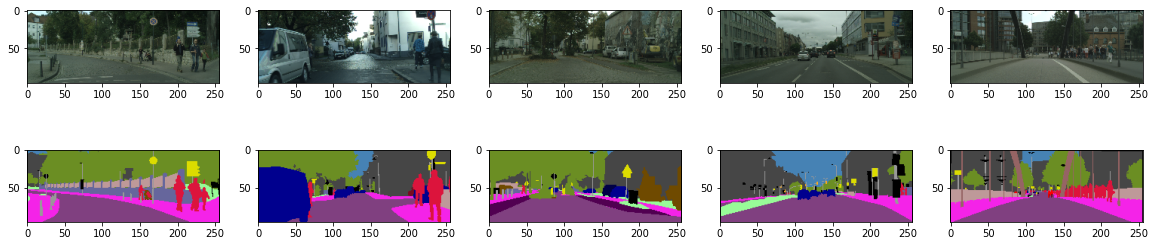

Validation


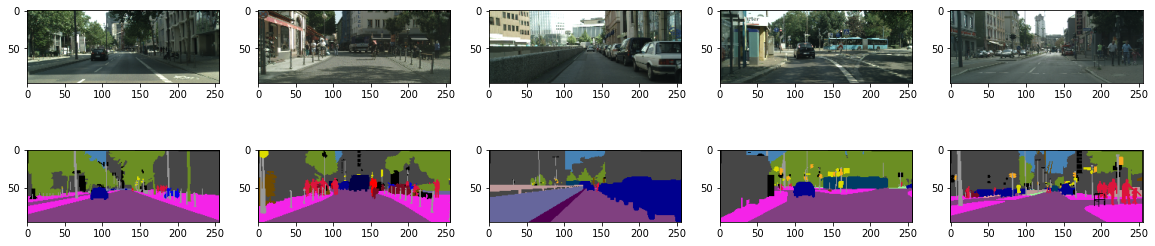

In [13]:
def visualize_image_mask(image_folder, mask_folder, image_paths, mask_paths, img_height = 96, img_width = 256):
    ''' Display 5 random images and their masks.
  
    Arguments:
      - image_folder (string): Path to the image folder
      - mask_folder (string): Path to the mask folder
      - image_paths (string list): Paths to images
      - mask_paths (string list): Paths to masks
      - img_height (int): Height to reshape -- 96
      - img_width (int): Width to reshape -- 256  '''

    idx = np.random.choice(len(image_paths), 5)

    images = [load_image(image_folder, image_paths[i], img_height, img_width) for i in idx]
    masks = [load_mask(mask_folder, mask_paths[i], img_height, img_width, one_hot = False) for i in idx]

    plt.figure(figsize = (20, 5))
    plt.subplots_adjust(hspace = 0.05)

    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.subplot(2, 5, i + 6)
        plt.imshow(masks[i])

    plt.show()

print('Train')
visualize_image_mask(train_images_folder_path, train_mask_folder_path, train_images_names, train_mask_names, img_height = img_height, img_width = img_width)
print('Validation')
visualize_image_mask(val_images_folder_path, val_mask_folder_path, val_images_names, val_mask_names, img_height = img_height, img_width = img_width)